# Libraries

In [2]:
# for working with data
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set2")

# for collecting data
import yfinance as yf

# for working with time series data
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for modelling
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

# for evaluation
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# for others
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Implementation

In [2]:
def collect_data(tickers="AAPL", start="2019-1-1", end="2024-4-15", saved_path=None, interval="1d"):
    data = yf.download(tickers=tickers, start=start, end=end, interval=interval, progress=False)
    if saved_path is not None:
        data.to_csv(f"{saved_path}.csv")
    else:   
        return data

def load_data(filename, date_column="Date"):
    data = pd.read_csv(filename)
    data[date_column] = pd.to_datetime(data[date_column])
    data = data.set_index(date_column)
    return data

In [3]:
def create_shiftback_dataset(raw, shift_back=3, start=None, end=None):
    columns = [f"lag_{i}" for i in range(shift_back, 0, -1)]
    data = pd.DataFrame([], columns=["Date"] + columns + ["Target"])
    raw = raw.loc[:end:]
    for i in range(shift_back, raw.shape[0]):
        values = [raw.iloc[i-shift] for shift in range(shift_back, -1, -1)]
        values = [raw.index[i]] + values
        data.loc[len(data.index)] = values
    
    data = data.set_index("Date")
    # data = data[list(data.columns[1:]) + ["Target"]]
    return data[start::]

In [4]:
def check_stationary_adf(data, significance_level=0.05, boolen_output=False, quiet=False):
    dftest = adfuller(data)
    p_value = dftest[1]
    stationary = p_value < significance_level
    if not quiet:
        print(f"p_value: {p_value}")
        if stationary:
            print("Data is stationary")
        else:
            print("Data is non-stationary")

    if boolen_output:
        return p_value < significance_level

In [5]:
def differencing(data, order=1):
    new_data = data.copy()
    while order > 0:
        new_data = new_data.diff().dropna()
        order -= 1
    return new_data

def diff_order(data, significance_level=0.05):
    order = 0
    data_diff = data.copy()
    while not check_stationary_adf(data_diff, significance_level, boolen_output=True, quiet=True):
        order += 1
        data_diff = data_diff.diff().dropna()
    return order

In [6]:
def acf_pacf(data, figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2, sharey=True)

    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    ax[0].set_ylim(top=1.15)
    plt.show()

# Load Data

In [7]:
try:
    data_org = load_data("data/dataset/AAPL_train.csv")
except:
    collect_data(saved_path="data/dataset/AAPL")
    data_org = load_data("data/dataset/AAPL_train.csv")

In [8]:
data = data_org[["Adj Close"]].copy()

# Data Exploration

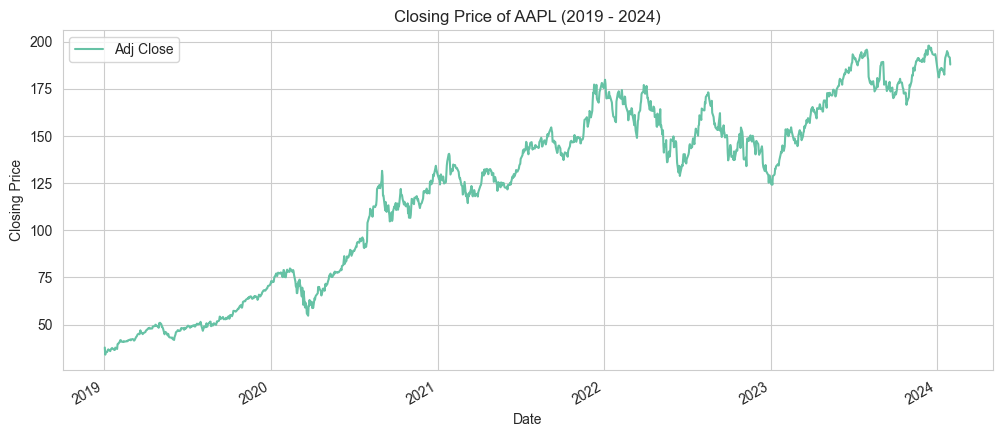

In [9]:
data.plot(figsize=(12, 5), title="Closing Price of AAPL (2019 - 2024)", ylabel="Closing Price")
plt.show()

__COMMENTS__
* upward trend
* non-stationary

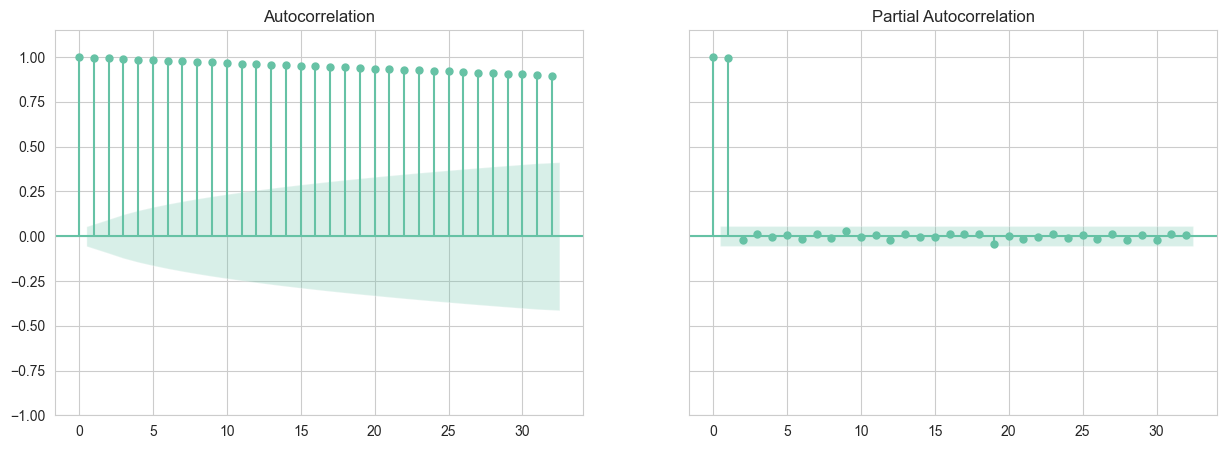

In [10]:
acf_pacf(data)

In [11]:
check_stationary_adf(data, significance_level=0.01)

p_value: 0.646812275201447
Data is non-stationary


# Differencing

In [12]:
print(f"Differencing order: {diff_order(data, significance_level=0.01)}")

Differencing order: 1


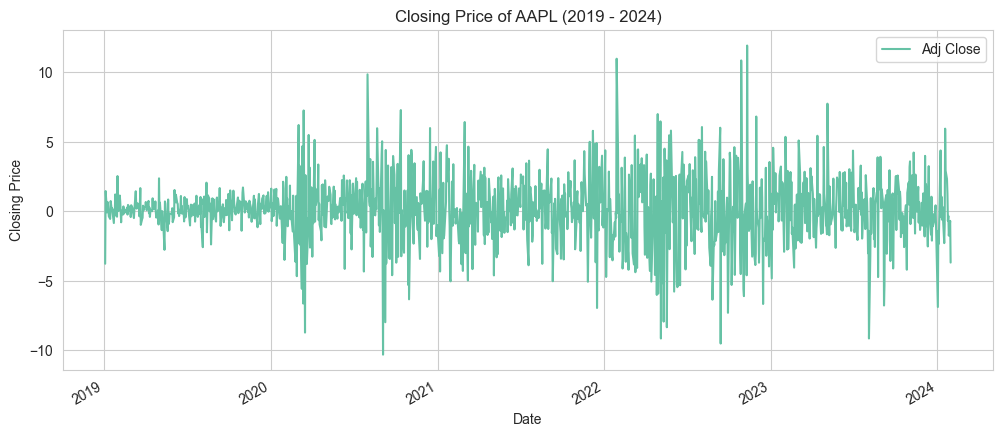

In [13]:
differencing(data, order=1).plot(figsize=(12, 5), title="Closing Price of AAPL (2019 - 2024)", ylabel="Closing Price")
plt.show()

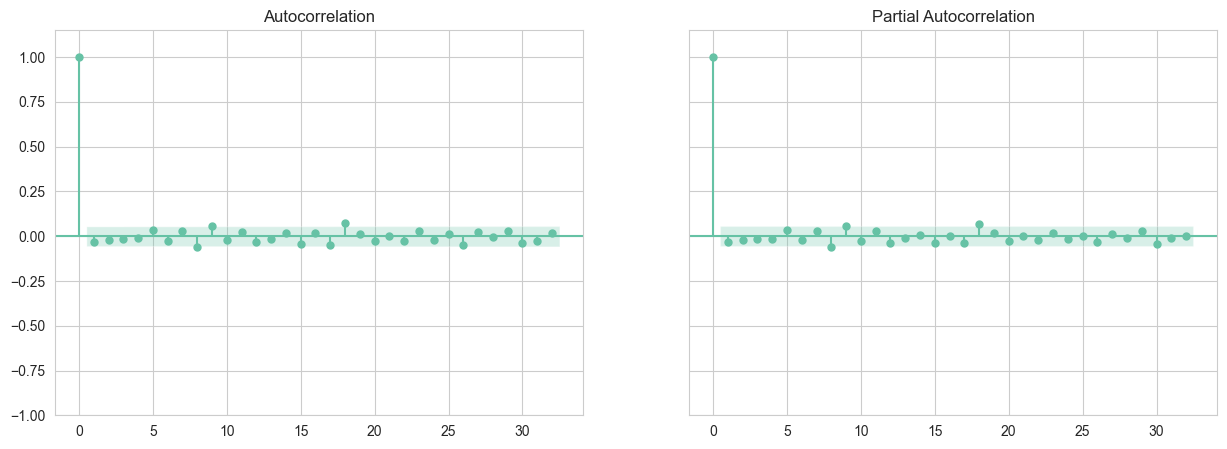

In [14]:
acf_pacf(differencing(data, order=1))

__COMMENTS__
* Data after the first differencing seems to be White Noise

# ARIMA

__Using Data From 01.2019 To 01.2024 To Predict Stock Price From 02.2024 to 04.2024__

In [15]:
train = load_data(filename=r"data\dataset\AAPL_train.csv")
test = load_data(filename=r"data\dataset\AAPL_test.csv")

In [16]:
def optimise_ARIMA(data, order_list=None, p=range(0, 6), d=range(0, 3), q=range(0, 6), summary_output=True):
    """
    Optimise ARIMA model
    
    :param order_list: list with (p, d, q) tuples
    :param exog: the exogenous variable

    :return: dataframe with parameters and corresponding AIC 
    """
    results = []
    
    if order_list is None:
        order_list = list(product(p, d, q))

    for order in tqdm(order_list):
        model = ARIMA(order=order, suppress_warnings=True).fit(data)
        results.append([order, model.aic()])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    if summary_output:
        return result_df.iloc[0, 0], result_df
    return result_df.iloc[0, 0]

In [17]:
run = False
if run:
    best_order, summary_finding = optimise_ARIMA(data["Adj Close"])
    print(f"Best order for ARIMA: {best_order}")
    summary_finding

__Using Data From 01.2019 To 01.2024 To Predict For The Next Period From 02.2024 To 04.2024__

In [18]:
best_arima = auto_arima(train["Adj Close"], start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=True,   # No Seasonality
                        trace=True,
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5829.240, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5829.671, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5829.599, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5830.378, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5830.836, Time=1.48 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.796 seconds


In [19]:
order = best_arima.order
model = ARIMA(train["Adj Close"], order=best_arima.order)
model_fit = model.fit()

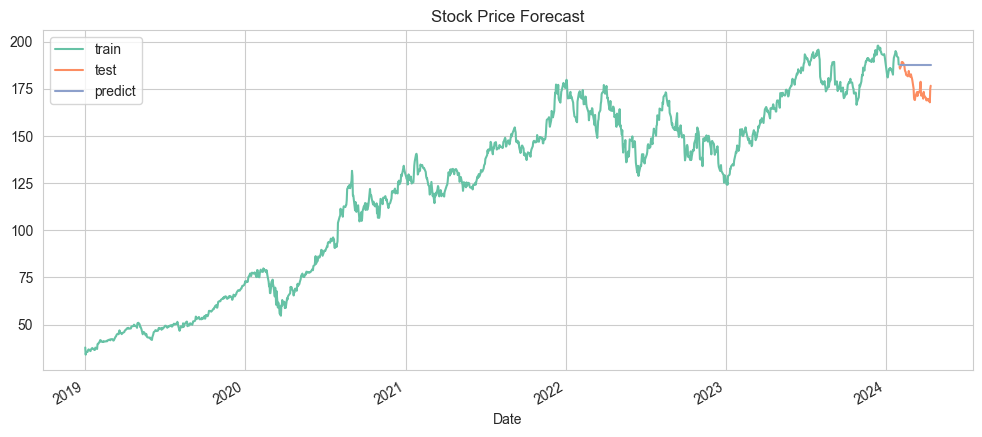

In [20]:
ax = train["Adj Close"].plot(figsize=(12, 5), label="train", title="Stock Price Forecast")
y_pred = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
y_pred = pd.DataFrame(y_pred.values, index=list(test.index), columns=["predict"])
test["Adj Close"].plot(ax=ax, label="test")
y_pred.plot(ax=ax, label="predict")
plt.legend()

In [21]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1278
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2914.189
Date:                Wed, 01 May 2024   AIC                           5830.378
Time:                        14:00:07   BIC                           5835.530
Sample:                             0   HQIC                          5832.312
                               - 1278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.6195      0.147     38.200      0.000       5.331       5.908
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               361.61
Prob(Q):                              0.21   Pr

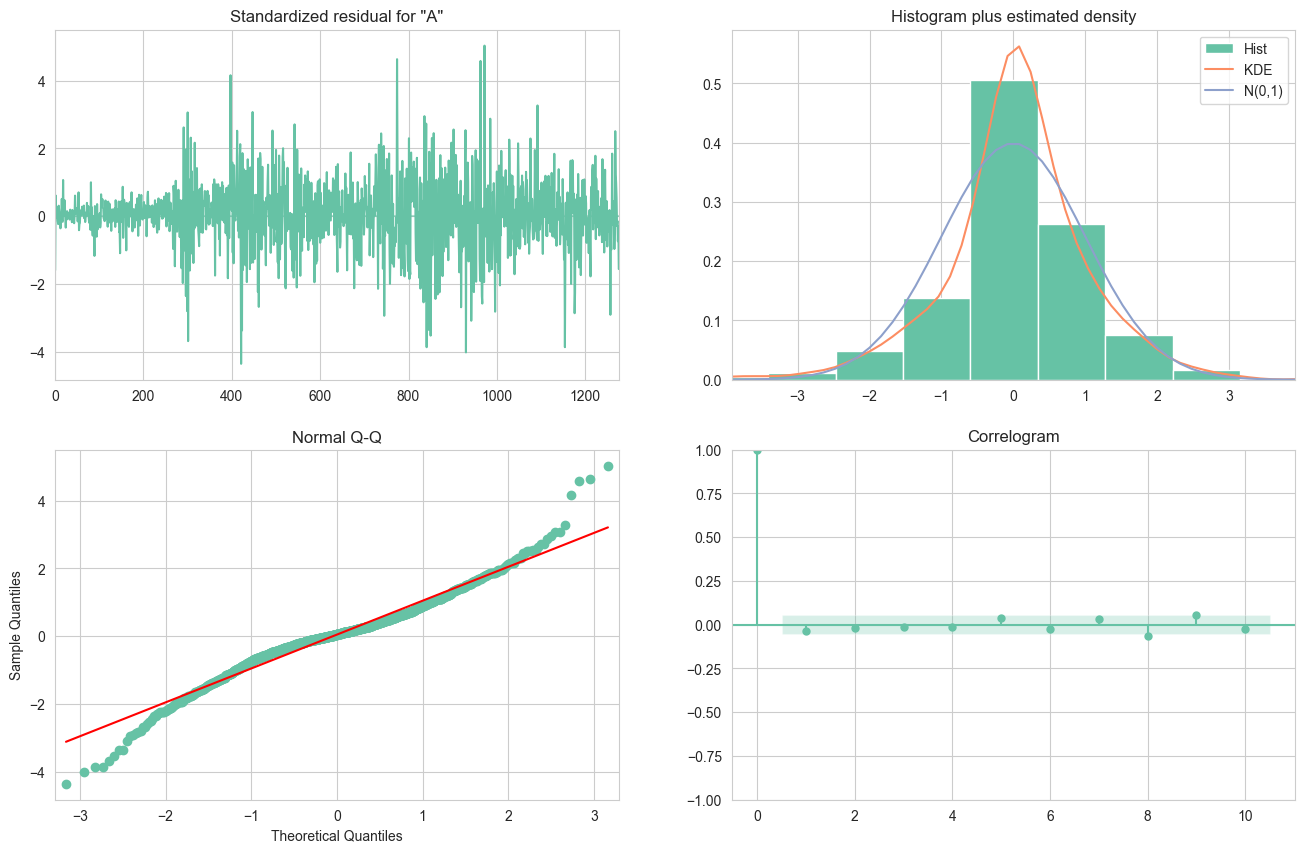

In [22]:
model_fit.plot_diagnostics(figsize=(16, 10))
plt.show()

In [23]:
print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Adj Close"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Adj Close"]))

RMSE: 12.774228677136971
MAPE: 0.0631606621140656


__Daily Forecasts - Data Updated After Each Day__

In [24]:
best_arima = auto_arima(train["Adj Close"], start_p=0, start_q=0,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q
                        d=None,           # let model determine 'd'
                        seasonal=True,   # No Seasonality
                        trace=False,
                        suppress_warnings=True,
                        stepwise=True)

order = best_arima.order
y_pred = []
model = ARIMA(train["Adj Close"].values, order=order)
model_fit = model.fit()
for i in range(-1, test.shape[0]-1, 1):
    if i > -1:
        model_fit = model_fit.append(test.iloc[i:i+1, -2].values)
    y_pred.append(model_fit.forecast(1))
y_pred = pd.DataFrame(y_pred, index=test.index, columns=["Predict"])

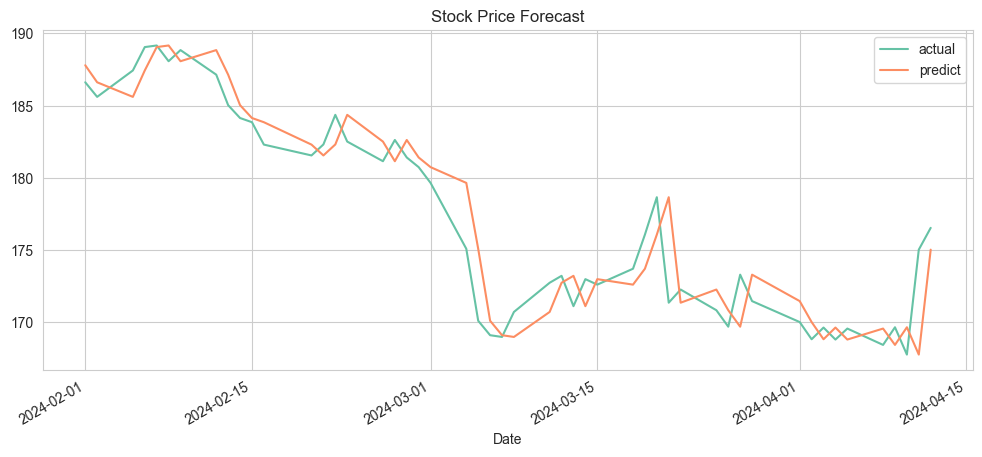

In [25]:
ax = test["Adj Close"].plot(figsize=(12, 5), label="actual", title="Stock Price Forecast")
# test["Adj Close"].plot(ax=ax, label="test")
y_pred["Predict"].plot(ax=ax, label="predict")
plt.legend()

In [26]:
print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Adj Close"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Adj Close"]))

RMSE: 2.247846655924602
MAPE: 0.009657146383194442


# FBProphet

__Using Data From 01.2019 To 01.2024 To Predict Stock Price From 02.2024 to 04.2024__

In [50]:
data = load_data(r"data\dataset\AAPL.csv")
train = data.loc["2019-1-1":"2024-1-31", "Adj Close"]
test = data.loc["2024-2-1":, "Adj Close"]
combine = pd.concat([train, test], axis=0)

In [51]:
model = Prophet()
model.fit(train.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"}))

14:06:39 - cmdstanpy - INFO - Chain [1] start processing
14:06:39 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
pred_dates = combine.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-02,38.249911,29.028575,47.485876
1,2019-01-03,38.008724,28.863425,48.037862
2,2019-01-04,37.766129,28.715440,46.936884
3,2019-01-07,37.483269,28.416287,47.155372
4,2019-01-08,37.101693,28.080661,46.690229


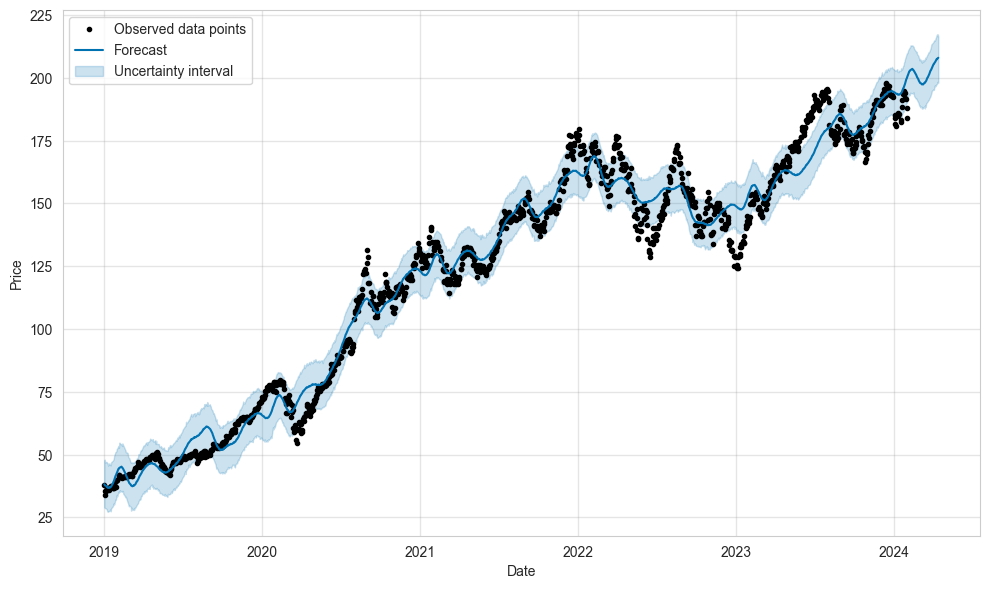

In [53]:
model.plot(forecast, include_legend=True)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

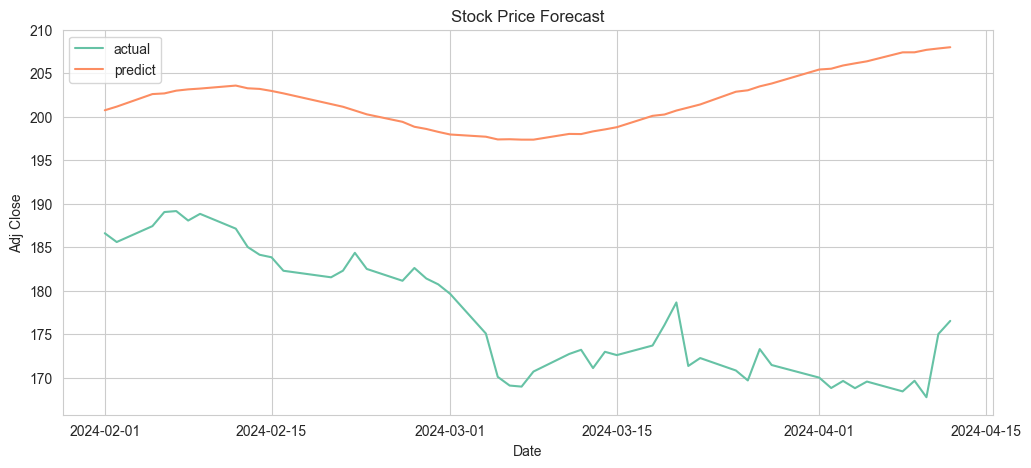

In [54]:
pred_dates = test.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)

plt.figure(figsize=(12, 5))
sns.lineplot(label="actual", x=test.index, y=test)
# test["Adj Close"].plot(ax=ax, label="test")
sns.lineplot(x=test.index, y=forecast["yhat"], label="predict")
plt.title("Stock Price Forecast")
plt.legend()

In [58]:
print("RMSE:", RMSE(y_pred=forecast['yhat'], y_true=test))
print("MAPE:", MAPE(y_pred=forecast['yhat'], y_true=test))

RMSE: 26.022202213490058
MAPE: 0.14189702653811812


__Daily Forecasts - Data Updated After Each Day__

In [ ]:
data = load_data(r"data\dataset\AAPL.csv")
train = data.loc["2019-1-1":"2024-1-31", "Adj Close"]
test = data.loc["2024-2-1":, "Adj Close"]
train = train.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"})
test = test.reset_index().rename(columns={"Date": "ds", "Adj Close": "y"})

In [33]:
pd.concat([train, test.iloc[0:1]], ignore_index=True)

,ds,y
0,2019-01-02,37.845039
1,2019-01-03,34.075397
2,2019-01-04,35.530052
3,2019-01-07,35.450966
4,2019-01-08,36.126770
...,...,...
1275,2024-01-26,192.174774
1276,2024-01-29,191.485657
1277,2024-01-30,187.800354
1278,2024-01-31,184.164993


In [46]:
y_pred = pd.DataFrame({"ds": [],
                       "yhat": []})
for i in range(-1, test.shape[0]-1, 1):
    if i == -1:
        train_fit = train
    else:
        train_fit = pd.concat([train_fit, test.iloc[i:i+1]], ignore_index=True)
    model = Prophet()
    model.fit(train_fit)
    test_fit = test.iloc[i+1:i+2, 0:1]
    predict = model.predict(test_fit)[['ds', 'yhat']]
    y_pred = pd.concat([y_pred, predict], ignore_index=True)

14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing
14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing
14:04:00 - cmdstanpy - INFO - Chain [1] start processing
14:04:00 - cmdstanpy - INFO - Chain [1] done processing
14:04:00 - cmdstanpy - INFO - Chain [1] start processing
14:04:00 - cmdstanpy - INFO - Chain [1] done processing
14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing
14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:01 - cmdstanpy - INFO - Chain [1] done processing
14:04:02 - cmdstanpy - INFO - Chain [1] start processing
14:04:02 - cmdstanpy - INFO - Chain [1] done processing
14:04:02 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1]

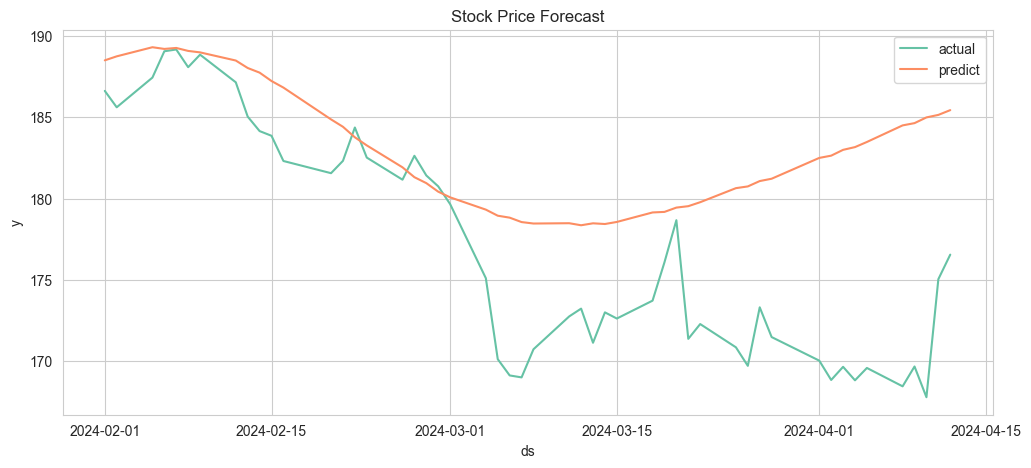

In [40]:
pred_dates = test.reset_index().rename(columns={"Date": "ds"})[["ds"]]
forecast = model.predict(pred_dates)

plt.figure(figsize=(12, 5))
sns.lineplot(label="actual", x=test['ds'], y=test['y'])
# test["Adj Close"].plot(ax=ax, label="test")
sns.lineplot(x=test['ds'], y=forecast["yhat"], label="predict")
plt.title("Stock Price Forecast")
plt.legend()

In [48]:
print("RMSE:", RMSE(y_pred=y_pred['yhat'], y_true=test["y"]))
print("MAPE:", MAPE(y_pred=y_pred['yhat'], y_true=test["y"]))

RMSE: 15.750983219307304
MAPE: 0.0879084605449851


# Linear Regression

In [95]:
data = load_data(r"data\dataset\AAPL.csv")[["Adj Close"]]
train = create_shiftback_dataset(raw=data['Adj Close'], shift_back=5, end="2024-1-31")
test = create_shiftback_dataset(raw=data["Adj Close"], shift_back=5, start="2024-2-1")

RMSE: 2.263860051728316
MAPE: 0.009871475783051132


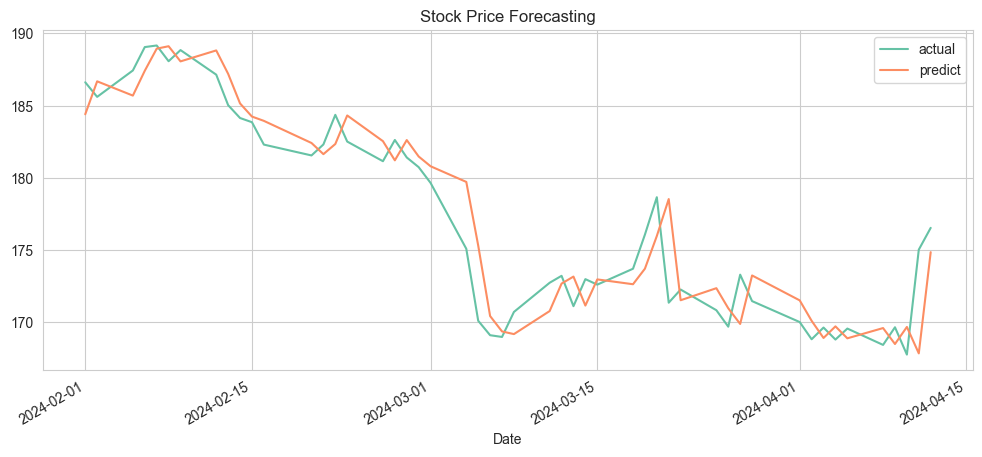

In [96]:
model = LinearRegression()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

# Random Forest

RMSE: 2.8272071769992793
MAPE: 0.012361017857978707


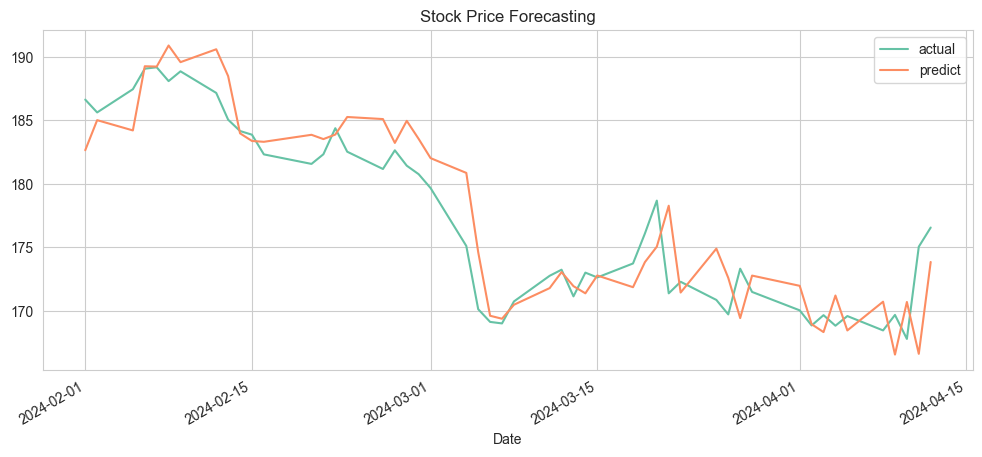

In [81]:
model = RandomForestRegressor(random_state=42)
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

# XGBoost

RMSE: 2.6533387403924062
MAPE: 0.011393736136296396


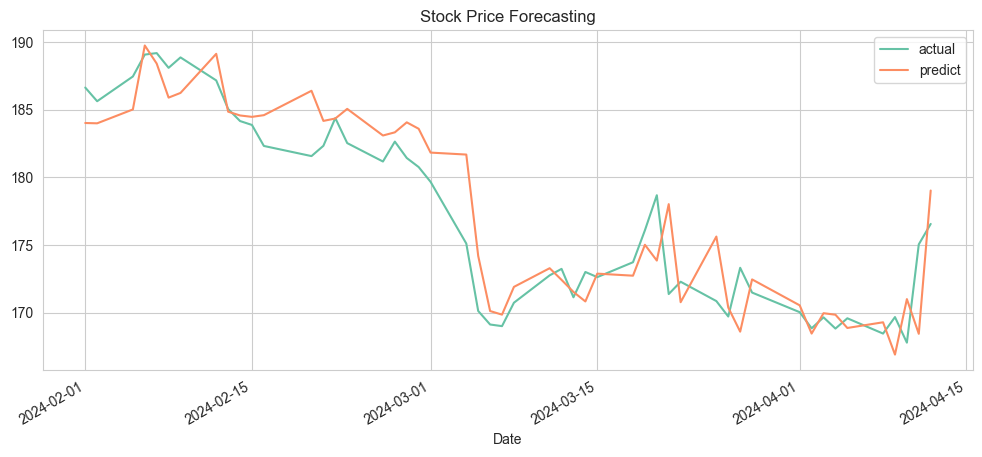

In [80]:
model = XGBRegressor(random_state=42)
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

# KNN

RMSE: 2.895485607781693
MAPE: 0.013798931280799367


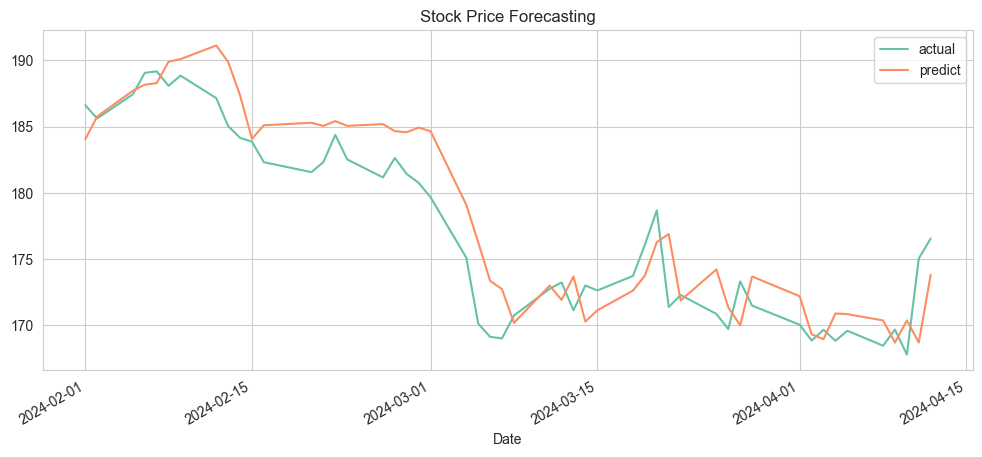

In [86]:
model = KNeighborsRegressor()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()

RMSE: 3.5317696680899964
MAPE: 0.016334010200559787


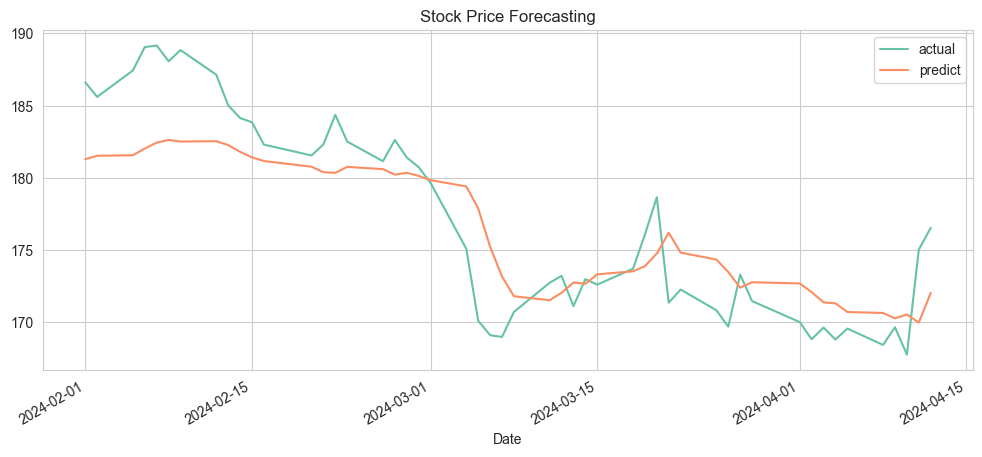

In [88]:
model = SVR()
model.fit(X=train.iloc[:, :-1], y=train.iloc[:, -1])
y_pred = model.predict(test.iloc[:, :-1])

print("RMSE:", RMSE(y_pred=y_pred, y_true=test["Target"]))
print("MAPE:", MAPE(y_pred=y_pred, y_true=test["Target"]))

test["Target"].plot(figsize=(12, 5), title="Stock Price Forecasting", label="actual")
sns.lineplot(x=test.index, y=y_pred, label="predict")
plt.legend()
plt.show()